In [1]:
y_config = """params:
  mass: 1.3e-12
  start: 0
  end: 500000
  steps: 100
  initial-conditions: [-1.5e-6, 100.e-6, 0, 0]

forces:
  - type: ray_tracer
    params:
      objects:
      - type: Sphere
        origin:
          type: offset
          value: [0,0]
        params:
          radius: 5.e-6
          n_in: 1.52
      ray-factory:
        type: AdaptiveGaussianRF
        origin:
          type: offset
          value: [0, -15.e-6]
        params:
          waist_origin: [0, 0]
          dir: [0,1]
          waist_radius: 3.4e-6
          power: 300.e-3
          n: 100
          wavelength: 532
          emit_radius: 5.e-6"""

In [2]:
import yaml
import forces.ray_tracer as rt
import tdt2

import sys
sys.path.append("../old code")
import single_sphere_kim
import beam_intensity

import matplotlib.pyplot as plt
import numpy as np

# New code

In [3]:
config = yaml.safe_load(y_config)
sim_params = config["params"]
rtf = rt.factory(config, config["forces"][0]["params"])
rtf(config["params"]["initial-conditions"], 0)

array([3.59271083e-11, 6.82002966e-11])

# Old code

In [4]:
class Inp:
    optical_switch = True
    target_n = config["forces"][0]["params"]["objects"][0]["params"]["n_in"]
    medium_n = 1
    polarisation='un_kim'
    target_radius = config["forces"][0]["params"]["objects"][0]["params"]["radius"]
    beam_type = "gaussian"
    W0 = config["forces"][0]["params"]["ray-factory"]["params"]["waist_radius"]
    wavelength = config["forces"][0]["params"]["ray-factory"]["params"]["wavelength"] * 1e-9
    power_profile = "constant"
    p_max = config["forces"][0]["params"]["ray-factory"]["params"]["power"]
    noise_switch = False
    c = 299792458
    target_abs = 0
inp = Inp()
single_sphere_kim.inp = inp
beam_intensity.inp = inp

In [5]:
init = config["params"]["initial-conditions"]
single_sphere_kim.optical_force([init[0], 0, init[1]], 0)

array([7.00277963e-11, 0.00000000e+00, 2.21306297e-10])

# Compare intensities

In [6]:
waist_radius = 3.4e-6
wavelength = 532
z = 0
power = 300.e-3
r=0

w = waist_radius * np.sqrt(1 + ((z*wavelength*1e-9)/(np.pi*waist_radius**2))**2)
intensities = np.sqrt(2 / np.pi) * power / w**2 * np.exp(-2 * r**2 / w ** 2)
print(intensities)

W=waist_radius*(1+((wavelength*1e-9*z)/(np.pi*waist_radius**2))**2)**0.5
I=((2.*power)/(np.pi*W**2.))*np.exp(-(2.*r**2.)/(W**2.))
print(I)

20706346733.638374
16521274369.4009


# Check weights

In [7]:
# rf = tdt2.AdaptiveGaussianRF(origin=[0,0], **config["forces"][0]["params"]["ray-factory"]["params"])
rf = tdt2.AdaptiveGaussianRF([0,0], [0,1], .25, 3, 100, 1, [0,0], 3)

In [8]:
np.sum(rf.weights) * 6.62607004e-25 * 299792458 / rf.wavelength

0.9549296585513724

# Compare x dependedce

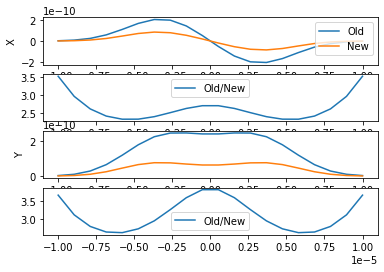

In [11]:
fig, ax = plt.subplots(4)
w = 10e-6
xs = np.linspace(-w, w, 20)
y = 50e-6
old_f = []
new_f = []
for x in xs:
    old_f.append(single_sphere_kim.optical_force([x, 0, y], 0))
    new_f.append(rtf([x, y, 0, 0], 0))
old_f = np.array(old_f)
new_f = np.array(new_f)

ax[0].plot(xs, old_f[:,0], label="Old")
ax[0].plot(xs, new_f[:,0], label="New")
ax[0].legend()
ax[0].set_ylabel("X")

ax[1].plot(xs, old_f[:,0]/new_f[:,0], label="Old/New")
ax[1].legend()

ax[2].plot(xs, old_f[:,2])
ax[2].plot(xs, new_f[:,1])
ax[2].set_ylabel("Y")

ax[3].plot(xs, old_f[:,2]/new_f[:,1], label="Old/New")
ax[3].legend()

plt.show()